In [92]:
#imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
import warnings

# suppress all warnings
warnings.filterwarnings("ignore")

In [93]:
#import data
test = pd.read_csv('titanic/test.csv')
train = pd.read_csv('titanic/train.csv')
gender_submission = pd.read_csv('titanic/gender_submission.csv') # example of submission file

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

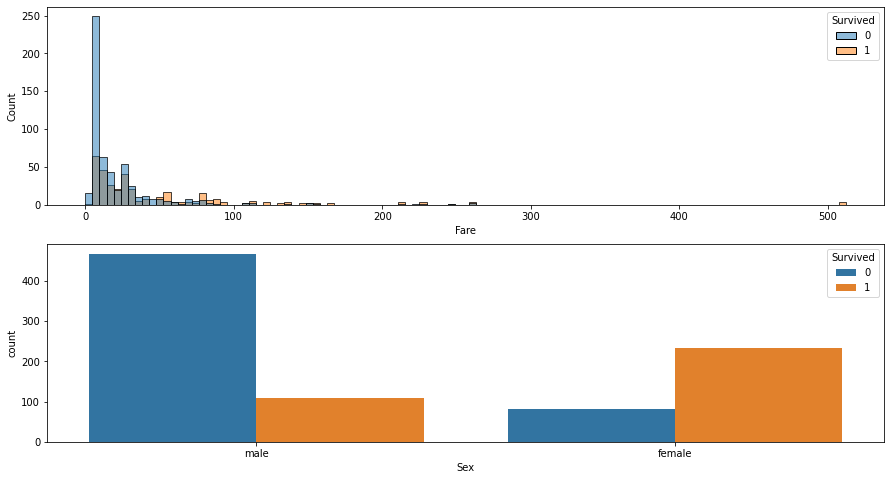

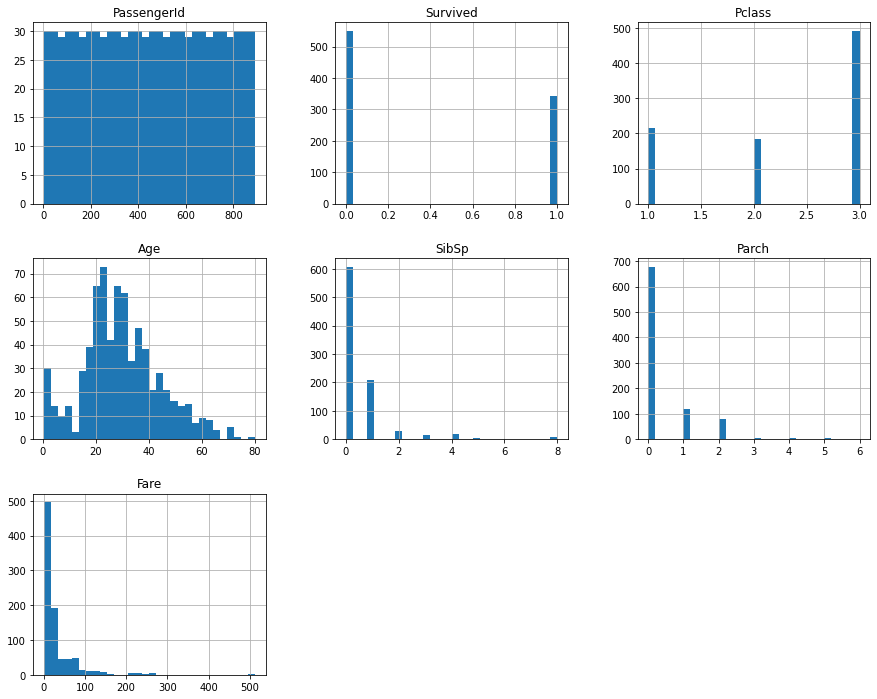

In [94]:
#explore data
train.info()
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,8))
sns.histplot(x = train['Fare'], hue = train['Survived'], ax=axs[0])
sns.countplot(x = train['Sex'], hue = train['Survived'], ax=axs[1])
train.hist(bins =30,figsize=(15,12))

In [95]:
train.info()
train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

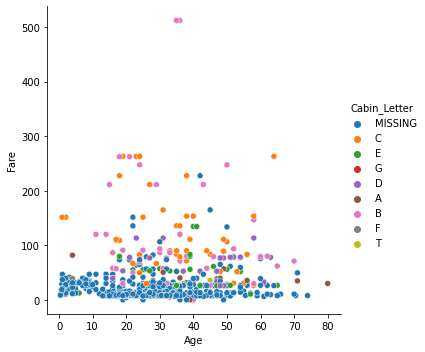

In [96]:
#sns.jointplot(x = train['Age'], y = train['Fare'])
#sns.scatterplot(x=train['Age'], y=train['Fare'], hue=train['Survived'], palette='coolwarm')

#make a new data column based on first letter of each cabin name
train['Cabin_Letter'] = train['Cabin'].str[0].fillna('MISSING')


#train['Cabin_Letter'].unique()
sns.relplot(data = train, x = 'Age', y = 'Fare', hue = 'Cabin_Letter')


#sns.hist(data = train, 'Cabin_Letter')


<AxesSubplot:xlabel='Ticket_Contains_Letter', ylabel='count'>

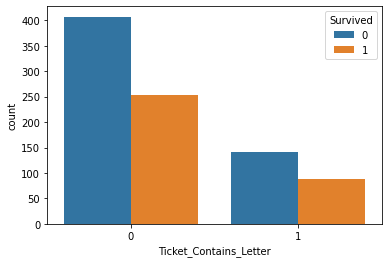

In [97]:
train['Ticket'].unique()

#some tieckets have letter in front of them
train['Ticket_Contains_Letter'] = train['Ticket'].str.contains('[a-zA-Z]').astype(int)

#train['Ticket_Contains_Letter'].value_counts()

sns.barplot(y=train['Survived'], x=train['Ticket_Contains_Letter'])




#sns.histplot(x = train['Ticket_Contains_Letter'], hue = train['Survived'], ax=axs[0])
sns.countplot(x = train['Ticket_Contains_Letter'], hue = train['Survived'])

In [98]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Cabin_Letter',
       'Ticket_Contains_Letter'],
      dtype='object')

In [99]:
# data cleaning: impute missing values, scale numerical

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

SimpleImputer.get_feature_names_out = (lambda self, names=None:
                                       self.feature_names_in_)

cat_cols = ['Sex']
untouched_cols = ['Pclass', 'SibSp', 'Parch']
int_cols = ['Pclass', 'SibSp']

def age_times_fare(df):
    df['age_times_fare'] = df['Age'] * df['Fare']
    return df

def cabin_transform(df):
    df['Cabin_Letter'] = df['Cabin'].str[0].fillna('MISSING')
    return df

def cabin_transform2(df):
    # Fill NA values with 0
    df['Cabin'] = df['Cabin'].fillna(0)
    # Replace non-zero values with 1
    df.loc[df['Cabin'] != 0, 'Cabin'] = 1
    return df
    
cabin_pipeline = make_pipeline(
    FunctionTransformer(cabin_transform2)#,
    #OneHotEncoder(drop='first', handle_unknown='ignore')
)

num_pipeline = make_pipeline(
    FunctionTransformer(age_times_fare),
    KNNImputer(n_neighbors=10),
    StandardScaler()
)

int_pipeline = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', handle_unknown='ignore')
)

cat_pipeline = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', handle_unknown='ignore')
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, make_column_selector(dtype_include='float')),
    ("int_cat", int_pipeline, int_cols),
    ("cat", cat_pipeline, cat_cols),
    ("cabin", cabin_pipeline, ['Cabin']),
    ('pass', 'passthrough', untouched_cols)
], remainder='drop')

In [100]:
#test some models to benchmark
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

#keep same ratio of sex, survived in train and test sets
strat_train_set, strat_test_set = train_test_split(train, test_size=0.2, stratify=train[['Sex', 'Survived']],random_state=42)

X_train = strat_train_set.drop('Survived', axis=1)
y_train = strat_train_set['Survived'].copy()

X_test = strat_test_set.drop('Survived', axis=1)
y_test = strat_test_set['Survived'].copy()

#logistic regressions
lin_reg = make_pipeline(preprocessing, LogisticRegression(max_iter=1000))
lin_reg.fit(X_train, y_train)
lin_pred = lin_reg.predict(X_test) #transforms predict data as well
reg_accuracy = accuracy_score(y_test, lin_pred)

#random forest
rfst = make_pipeline(preprocessing, RandomForestClassifier(n_estimators=1000, random_state=1))
rfst.fit(X_train, y_train)
rfst_pred = rfst.predict(X_test)
rfst_accuracy = accuracy_score(y_test, rfst_pred)

#SVM
svm = make_pipeline(preprocessing, SVC(kernel='rbf', C=100, gamma='scale'))
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)

#Gradient Boost
gb = make_pipeline(preprocessing, GradientBoostingClassifier())
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

#KNN
knn = make_pipeline(preprocessing, KNeighborsClassifier(n_neighbors=15))
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)


print('Logistic Regression Accuracy:', reg_accuracy)
print('Random Forest Accuracy:', rfst_accuracy)
print('Support Vector Machine Accuracy:', svm_accuracy)
print('Gradient Boost Accuracy:', gb_accuracy)
print('K Nearest Neighbors Accuracy:', knn_accuracy)


Logistic Regression Accuracy: 0.8435754189944135
Random Forest Accuracy: 0.8100558659217877
Support Vector Machine Accuracy: 0.8100558659217877
Gradient Boost Accuracy: 0.8435754189944135
K Nearest Neighbors Accuracy: 0.8379888268156425


In [101]:
#Logistic Regression Accuracy: 0.8044692737430168
#Random Forest Accuracy: 0.8268156424581006
#Support Vector Machine Accuracy: 0.7094972067039106
#Gradient Boost Accuracy: 0.8491620111731844
#K Nearest Neighbors Accuracy: 0.7039106145251397

In [102]:
#using kfolds cross validation

from sklearn.model_selection import cross_val_score

#Gradient Boost with cross-validation
gb = make_pipeline(preprocessing, GradientBoostingClassifier())
scores = cross_val_score(gb, X_train, y_train, cv=20)
mean_score = scores.mean()

print('Mean cross-validation accuracy score:', round(mean_score, 4))

#0.8189

#pd.Series(scores).describe()

Mean cross-validation accuracy score: 0.8315


In [103]:
#benchmark 

from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()

dummy.fit(X_train, y_train)

dummy_pred = dummy.predict(X_test)

accuracy_score(y_test, dummy_pred)

#benchmark of 61% using most common class

0.6145251396648045

In [104]:
#hyperparamter tuning on gb model only

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.pipeline import Pipeline


full_pipeline = Pipeline([
    ('preprocessor', preprocessing),
     ('classifier', GradientBoostingClassifier())])

param_distributions = {
    'preprocessor__num__knnimputer__n_neighbors': [5, 10, 20, 30],
    'preprocessor__num__knnimputer__n_neighbors': [5, 10, 20, 30],
    'classifier__n_estimators': [100, 500, 2000],
    'classifier__learning_rate': [0.01, 0.1, 0.5],
    'classifier__max_depth': [3, 8, 50]
}

random_search = RandomizedSearchCV(
    full_pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=5, 
    scoring='accuracy', 
    verbose=2, 
    n_jobs=-1, 
    random_state=43
)

results = random_search.fit(X_train, y_train)

print(results.best_score_)
print(results.best_params_)

# summarize best
print('Best MAE: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)

#0.8272727272727272

best_gb_model = random_search.best_estimator_

print(random_search.best_params_)


#we should hyperparam tune other models in ensemble and throw them in with correct params

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.8244656751699004
{'preprocessor__num__knnimputer__n_neighbors': 20, 'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}
Best MAE: 0.824
Best Config: {'preprocessor__num__knnimputer__n_neighbors': 20, 'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}
{'preprocessor__num__knnimputer__n_neighbors': 20, 'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}


In [105]:
#next step is either improve model / pre processing or try ensemble model?
print(random_search.best_params_)

{'preprocessor__num__knnimputer__n_neighbors': 20, 'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}


In [106]:
#ensemble method with 3 models

from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier


# define the individual models
#model1 = LogisticRegression(max_iter=1000)
best_gb_model = GradientBoostingClassifier(max_depth=3, learning_rate=0.01) 
model3 = RandomForestClassifier()

# create the ensemble model

ensemble_model = VotingClassifier(estimators=[('gb', best_gb_model), ('rf', model3)], voting='soft')

# combine the pipelines with the ensemble model
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('ensemble_model', ensemble_model)
])

# fit the pipeline on the data
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function age_times_fare at 0x15f9be680>)),
                                                                  ('knnimputer',
                                                                   KNNImputer(n_neighbors=10)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x158c7a050>),
                                                 ('int_cat',
                                                  Pipe...
                                                                                 handle_unknown='ignore'))]),
                                                  ['Sex']),
                                                 ('cabin',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function cabin_transform2 at 0x15f9be320>))]),
                                                  ['Cabin']),
                                                 ('pass', 'passthrough',
                                                  ['Pclass', 'SibSp',
                                                   'Parch'])])),
                ('ensemble_model',
                 VotingClassifier(estimators=[('gb',
                                               GradientBoostingClassifier(learning_rate=0.01)),
                                              ('rf', RandomForestClassifier())],
                                  voting='soft'))])

In [127]:
from sklearn.model_selection import RandomizedSearchCV

# define the hyperparameters to search over
param_dist = {
    'preprocessing__num__knnimputer__n_neighbors': [5, 7, 8, 9, 20],
    'ensemble_model__rf__n_estimators': [100, 200, 300, 500],
    'ensemble_model__rf__max_depth': [2, 5, 10, 15, 20, 25],
}

# create the randomized search object
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, cv=5)

random_search.fit(train.drop('Survived', axis=1), train['Survived'].copy())


# print the best hyperparameters
results = random_search.fit(X_train, y_train)

print(results.best_score_)
print(results.best_params_)

# summarize best
print('Best MAE: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)

#random_search.get_params().keys() #this shows you which hyperparams you can change

#0.8440953412784399 highest we got so far

# Extract the best model from the search object
best_model = random_search.best_estimator_

0.841327686398109
{'preprocessing__num__knnimputer__n_neighbors': 8, 'ensemble_model__rf__n_estimators': 100, 'ensemble_model__rf__max_depth': 10}
Best MAE: 0.841
Best Config: {'preprocessing__num__knnimputer__n_neighbors': 8, 'ensemble_model__rf__n_estimators': 100, 'ensemble_model__rf__max_depth': 10}


In [128]:
#fit the whole model on the whole training



y_pred = best_model.predict(test)


submit_df = pd.DataFrame()

submit_df['PassengerId'] = test['PassengerId']
submit_df['Survived'] = y_pred
submit_df.to_csv('BenJakepredictions2.csv', index=False)